In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/../src/simulations_v2")
    sys.path.append(module_path + "/..")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *
from plot_utils import *
configure_plot(plt)

In [3]:
lhs_output_sim_files = []
for i in range(2000):
    fname = '/home/aaj54/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
    lhs_output_sim_files.append(fname)

In [4]:
scenario_data = load_sim_output(lhs_output_sim_files)
res_results = residential_regression(scenario_data)
res_pessimistic = calculate_pessimistic_scenario(res_results)

In [5]:
results_summary = res_results.summary()
results_as_html = results_summary.tables[1].as_html()
lr_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

coef_normalized = list()
for param, value in dict(lr_summary_df['coef']).items():
    if param == 'const':
        coef_normalized.append(value)
        continue
    param_range = PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0]
    coef_normalized.append(value * param_range)
lr_summary_df['coef*range'] = coef_normalized

In [11]:
# lr_summary_df.columns
lr_summary_df[['coef', 'std err', 'P>|t|', 'coef*range']].round(3)

,coef,std err,P>|t|,coef*range
const,1014.736,429.208,0.018,1014.736
asymp_prob_mult,570.451,60.968,0.000,558.314
inital_prev_mult,184.444,59.783,0.002,184.444
R0,409.106,19.885,0.000,1227.319
outside_inf_mult,86.657,59.519,0.146,86.657
daily_self_report_prob,-623.027,212.976,0.003,-174.448
ct_mult,-659.728,59.618,0.000,-659.728
ct_testing_ratio,-571.213,59.603,0.000,-571.213
test_sensitivity,-1771.662,149.238,0.000,-708.665
test_noncompliance,1855.755,596.420,0.002,185.576


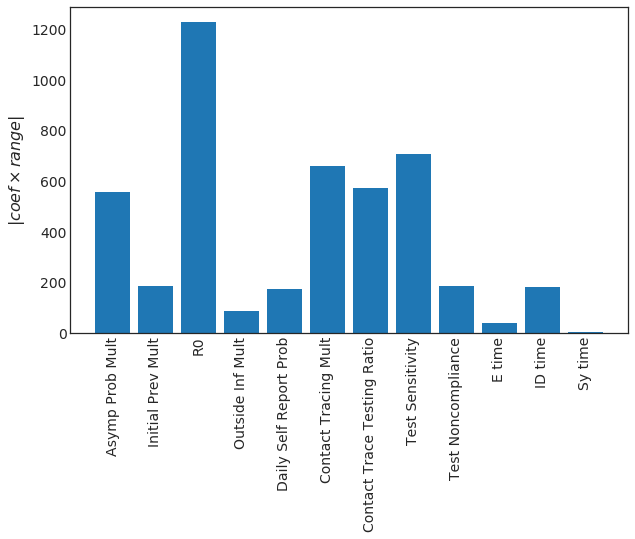

In [10]:
plt.figure(figsize=(10,6))
plt.bar(lr_summary_df.index[1:], np.abs(lr_summary_df['coef*range'])[1:])
# plt.ylabel('|coef * range|')
plt.ylabel(r"$\| coef \times range \|$")
# plt.xlabel('Feature')
# plt.xticks(rotation = 90)
plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST[:12]))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'E time', 'ID time', 'Sy time'], rotation=90)

plt.show()

In [8]:
def normalize_param(param_name, value):
    lower_bound = PARAM_BOUNDS[param_name][0]
    upper_bound = PARAM_BOUNDS[param_name][1]
    return (value - lower_bound) / (upper_bound - lower_bound)

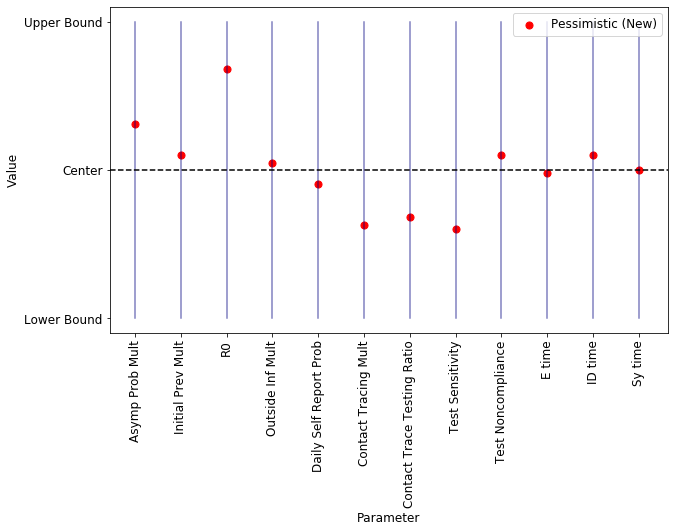

In [9]:
plt.figure(figsize=(10,6))
label = True

for index, param in enumerate(UNCERTAINTY_PARAMS_LIST[:12]):
    plt.plot([index, index], [0,1], color='navy', alpha=0.5)
    if label == True:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', label='Pessimistic (New)', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', s=50)

plt.axhline(0.5, color='black', ls='--')

plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST[:12]))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'E time', 'ID time', 'Sy time'])
plt.xticks(rotation = 90)
plt.yticks([0,0.5,1], ['Lower Bound', 'Center', 'Upper Bound'])

plt.xlabel('Parameter')
plt.ylabel('Value')

plt.legend(loc='upper right')
plt.show()

In [10]:
res_pessimistic, PARAM_BOUNDS

({'ct_testing_ratio': 0.8408882933907234,
  'outside_inf_mult': 1.0241384070908397,
  'E_time': 1.9781058849148887,
  'ct_mult': 1.3162323939656833,
  'ID_time': 3.1001602001642996,
  'R0': 3.525611538430936,
  'daily_self_report_prob': 0.34639409513141284,
  'test_noncompliance': 0.10516921933568774,
  'asymp_prob_mult': 1.1522097816900698,
  'Sy_time': 11.99746235017504,
  'test_sensitivity': 0.5210403803934798,
  'inital_prev_mult': 1.0513769799456971,
  'virtual_noncompliance': 0.5,
  'intermittent_non-compliance': 0.5,
  'virtual_r0_mult': 1.2349999999999999,
  'virtual_pop_size': 0.5},
 {'asymp_prob_mult': (0.5106382978723404, 1.4893617021276595),
  'inital_prev_mult': (0.5, 1.5),
  'R0': (1, 4),
  'outside_inf_mult': (0.5, 1.5),
  'daily_self_report_prob': (0.22, 0.5),
  'ct_mult': (1, 2),
  'ct_testing_ratio': (0.5, 1.5),
  'test_sensitivity': (0.4, 0.8),
  'test_noncompliance': (0.05, 0.15),
  'E_time': (1, 3),
  'ID_time': (2, 4),
  'Sy_time': (11, 13),
  'virtual_noncomplian